In [131]:
import pylab as plt
import numpy as np
from cartopy import crs as ccrs
from netCDF4 import Dataset
import xarray as xr
from scipy import ndimage
from scipy.optimize import minimize

import sys as sys
import pickle
import glob as glob
import datetime as dt

sys.path.append('/home/ardhuin/TOOLS/swellSWOT/src/')
import swot_ssh_utils as swot
import swot_swell_utils as swell
from  lib_filters_obp import *


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
import cmocean
import cmocean.cm as cmo
lightcmap = cmocean.tools.lighten(cmo.ice, 1)

import ipywidgets as widgets
from ipywidgets import interactive


#PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
#sys.path.append(PATH_with_functions)
from  spectral_analysis_functions import *
from  wave_physics_functions import *
plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

In [132]:
#mypath='/home/ardhuin/PUBLI/2025_Bolaven/data_package/'
#folder='/media/ardhuin/FabLinux/SWOT_SPECTRA_TEST3/';tag='v2.1_light'

#folder=mypath+'data/storm_Manoa_20241102T05/';tag='v2.1_light';level='L2'

# plotting parameters
doplot=0
figh=7;locleg='upper right';ileg=1;  figh=7;Hmaxp=1.4;
# information about storm center
lo1=-173.5;la1=42.0; t1=np.datetime64('2023-10-16 01', 'ns'); rl=[600,1050];Lrange=[400,1200];cols='r'


# partition processing parameters
tola=1E6;tolr=0.3;thrcos=0.89;



# choice of SWOT track 
folder=mypath+'data/storm_Bolaven_20231016T01/';tag='v2.1_light';level='L3'
cycle='005';tracks='328';figh=5.;latrange=[-65,20];Lrange=[400,1200];Lstep=200;thrange=[210,330];thstep=30;Hrange=[0,2];locleg='upper right';ileg=1;  figh=7;drange=[9000,16000]
drange=[7000,19000]

# Storm Moea
#lo1=-176;la1=49.5; t1=np.datetime64('2023-10-12 14', 'ns'); 
#cycle='005';tracks='300';drange=[11000,18000];Hmaxp=0.5;figh=5.;rl=[500,600];Lrange=[400,900];cols='b';latrange=[-65,20];Lstep=200;thrange=[210,330];thstep=30;Hrange=[0,2];locleg='upper right';ileg=1;  figh=7;

# Storm Eddie
#lo1=-161;la1=38.5; t1=np.datetime64('2024-12-21 15', 'ns'); rl=[650,1300];Lrange=[400,1200];cols='r'
#folder=mypath+'data/SWOT_data_by_storm/storm_Eddie_20241221T15/';tag='v2.1_light';level='L2'
#folder='/media/ardhuin/FabLinux/SWOT_SPECTRA_TEST3/';tag='v2.1_light'
#cycle='026';tracks='024';figh=5.;latrange=[-20,50];Lrange=[600,1600];Lstep=200;thrange=[210,330];thstep=30;Hrange=[0,4];locleg='upper right';ileg=1;  figh=7;drange=[3000,6000];Hmaxp=4


tracktag='cycle '+cycle+', track '+tracks;
filepattern=folder+'SWOT_'+level+'_LR_WIND_WAVE_'+cycle+'_'+tracks+'*'+tag+'.nc'
print('looking for files:',filepattern ) 
file_listnc = sorted(glob.glob(filepattern ));

ntrack=int(tracks)
sflip=0 #np.mod(ntrack,2)
print('sflip:',sflip,' ',file_listnc[0])
L3Snc=xr.open_dataset(file_listnc[0])
print(L3Snc.dims) 



# computes partitions 
dimt='time'
dimb='n_box'

varE='Efxfy_SWOT'
varkx='fx2D'
varky='fy2D'
varta='track_angle'
[nbox,nfy,nfx]=np.shape(L3Snc[varE])
print('spec:',np.shape(L3Snc[varE]))
varh='H18'
varl='L18'
vard='phi18'
varlat='latitude'
varlon='longitude'
L3Snb=len(L3Snc[varh])
ncross=2
L3Snx=ncross
L3Snt=L3Snb//L3Snx

Hpart=np.zeros((L3Snb))
Hpart_nonoise=np.zeros((L3Snb))
Lpart=np.zeros((L3Snb))
dpart=np.zeros((L3Snb))
spart=np.zeros((L3Snb))
Qpart=np.zeros((L3Snb))
alpha=np.zeros((L3Snb))
beta =np.zeros((L3Snb))
partmask=np.zeros((nbox,nfy,nfx))
dtor=np.pi/180

HH1=L3Snc.filter_OBP.values*L3Snc.filter_PTR.values

ibox=-1
for indt in range(L3Snt): 
  for indx in range(L3Snx): 
    ibox=ibox+1 #L3Snc.ind_box[indt, indx]
    la2=L3Snc[varlat][ibox].values
    lo2=L3Snc[varlon][ibox].values
    alpha[ibox],beta[ibox]=swell.dist_sphere(lo1,lo2,la1,la2)
    angt=L3Snc[varta][ibox].values
    now=L3Snc.time[ibox].values
    #print('now:',now)

    tdiff=(now-t1);
    tds = tdiff / np.timedelta64(1, 's')
    kx2=L3Snc[varkx].values
    ky2=L3Snc[varky].values
    bmask,cmask=swell.SWOTdefine_swell_mask_storm(kx2,ky2,angt-180,lo1,la1,lo2,la2,tds,tola=tola,tolr=tolr,thrcos=thrcos)
    #bmask=L3Snc['mask][indt].values  # this is the model-based mask in the CNES file
    partmask[ibox,:,:]=bmask
  
    nmask=np.sum(bmask.flatten())

    if nmask > 1:
       E_SWOT=L3Snc[varE][ibox,:,:].values
       #print('SHAPE:',E_SWOT.shape,bmask.shape,kx2.shape)
       Hsnew,Lmm1new,LE,Lmnew,dmnew,spr,Q18=swell.SWOTspec_to_HsLm(E_SWOT,kx2,ky2,bmask,E_SWOT*0+1,angt)
       
       #print('al:',indt,nmask,la2,lo2,alpha[indt,indy,indx],Hsnew,Lmm1new,LE,Lmnew,dmnew,spr,Q18)
       Hpart[ibox]=Hsnew 
       Lpart[ibox]=LE 
       dpart[ibox]= (dmnew + 180) % 360  
       spart[ibox]=spr 
       Qpart[ibox]=Q18 

       Ekth,kn1,theta1,E_SWOT_nonoise=swell.SWOT_denoise_isotropic(E_SWOT,kx2,ky2)
       Hsnew,Lmm1new,LE,Lmnew,dmnew,spr,Q18=swell.SWOTspec_to_HsLm(E_SWOT_nonoise,kx2,ky2,bmask,E_SWOT*0+1,angt)
       Hpart_nonoise[ibox]=Hsnew
       if (doplot==1 & indt > 300 & np.mod(indt,50)==0):
          vertices=swell.SWOTspec_mask_polygon(bmask) 
          fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,11.5))
          plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)
          im=ax[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT),cmap='viridis',rasterized=True,vmin=10, vmax=60)
          _=plt.colorbar(im,ax=ax[0],label='', location='bottom',shrink=0.8)
          _=ax[0].set_title('spectrum SWOT (dB)'+f'{la2:03.1f}')
          swell.arrows_on_spectrum(ax[0],1-sflip,indx,L3Snc.track_angle[indt],color='k')

          dkx=kx2[0,1]-kx2[0,0]
          dky=ky2[1,0]-ky2[0,0]
          swell.draw_mask(ax[0],kx2,dkx,ky2,dky,vertices,color='w',lw=3)


looking for files: /home/ardhuin/PUBLI/2025_Bolaven/data_package/data/storm_Bolaven_20231016T01/SWOT_L3_LR_WIND_WAVE_005_328*v2.1_light.nc
sflip: 0   /home/ardhuin/PUBLI/2025_Bolaven/data_package/data/storm_Bolaven_20231016T01/SWOT_L3_LR_WIND_WAVE_005_328_20231024T085717_20231024T094843_v2.1_light.nc
Frozen({'n_box': 984, 'n_along': 492, 'n_cross': 2, 'nind': 4, 'nfy': 21, 'nfx': 20, 'nf': 36, 'nphi': 24})
spec: (984, 21, 20)


In [133]:
L3Snc=L3Snc.assign({'Hpart' : ((dimb),Hpart)})
L3Snc=L3Snc.assign({'Hpart_nonoise' : ((dimb),Hpart_nonoise)})
L3Snc=L3Snc.assign({'Lpart' : ((dimb),Lpart)})
L3Snc=L3Snc.assign({'dpart' : ((dimb),dpart)})
L3Snc=L3Snc.assign({'spart' : ((dimb),spart)})
L3Snc=L3Snc.assign({'Qspart' : ((dimb),Qpart)})
L3Snc=L3Snc.assign({'alpha' : ((dimb),alpha)})
L3Snc=L3Snc.assign({'beta' : ((dimb),beta)})
L3Snc = L3Snc.assign({'partmask': (('dimb', 'nfy', 'nfx'), partmask)})


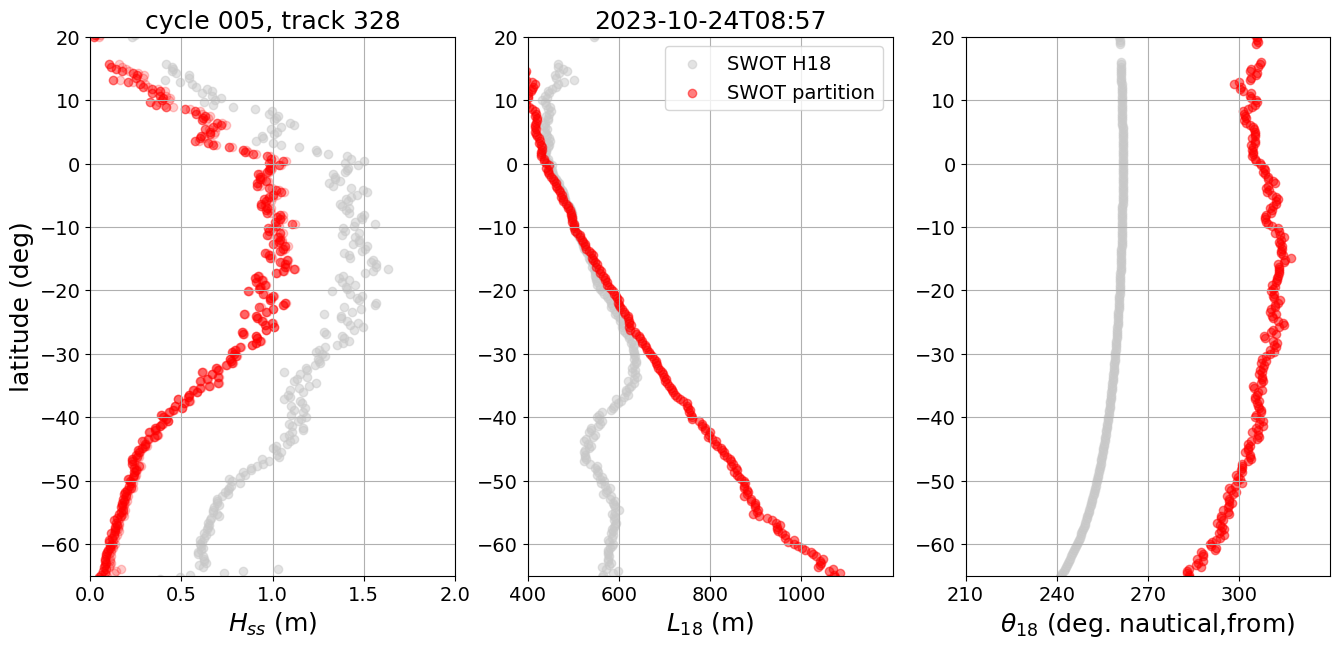

In [134]:
gr=[0.,205./255.,0.]
if 'lambdac' in L3Snc.data_vars:
    fig,axs=plt.subplots(1,4,figsize=(16,figh))
else:
    fig,axs=plt.subplots(1,3,figsize=(16,figh))

vecHs=np.linspace(1,12,23)

timec=L3Snc.time[0].values

gr=[[200./255.,200./255.,200./255.]]
gS=[[80./255.,255./255.,80./255.]]
lat0=L3Snc[varlat][1:-1:2].values
#axs[0].scatter(L3Snc[varlat][:,0,0].values,lat0,c='black',linewidth=1,label='model');
axs[0].scatter(L3Snc[varh][1:-1:2].values,lat0,c=gr,alpha=0.5,linewidth=1,label='SWOT H18');
axs[0].scatter(L3Snc.Hpart[1:-1:2].values,lat0,c=cols,alpha=0.2,linewidth=1,label='SWOT partition');
axs[0].scatter(L3Snc.Hpart_nonoise[1:-1:2].values,lat0,c=cols,alpha=0.5,linewidth=1,label='SWOT denoised');
#   if (denoise==1):
#      axs[0].scatter(bigarray_L3S[s1:-1,12],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');
   
    
axs[0].set_xlabel(r'$H_{ss}$ (m)', fontsize=18)
axs[0].set_ylabel('latitude (deg)', fontsize=18)
axs[0].set_title(tracktag, fontsize=18)
axs[0].set_xlim(Hrange);
#axs[0].set_xlim([0,5]);
axs[0].set_ylim(latrange)

axs[1].scatter(L3Snc[varl][1:-1:2].values,lat0,c=gr,alpha=0.5,linewidth=1,label='SWOT H18');
axs[1].scatter(L3Snc.Lpart[1:-1:2].values,lat0,c='r',alpha=0.5,linewidth=1,label='SWOT partition');

#if (denoise==1):
#      axs[1].scatter(bigarray_L3S[s1:-1,22],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[1].set_xlabel(r'$L_{18}$ (m)', fontsize=18)
format = '%Y-%m-%dT%H:%M:%S'
axs[1].set_title(str(timec)[0:16], fontsize=18)
axs[1].set_xlim(Lrange)
axs[1].set_xticks(np.arange(Lrange[0],Lrange[1],Lstep))
#axs[1].set_xlim([450,650])
#axs[1].set_xticks(np.arange(450,650,50))
axs[1].set_ylim(latrange)
leg = axs[ileg].legend(loc=locleg, fontsize=14)



#axs[2].scatter(bigarray_L3S[s1:-1,31],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
axs[2].scatter(L3Snc[vard][1:-1:2].values+180,lat0,c=gr,alpha=0.5,linewidth=1,label='SWOT d18');
axs[2].scatter(L3Snc.dpart[1:-1:2].values+180,lat0,c='r',alpha=0.5,linewidth=1,label='SWOT partition');
#   if (denoise==1):
#     axs[2].scatter(bigarray_L3S[s1:-1,32],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');
#     axs[2].scatter(bigarray_L3S[s1:-1,32],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[2].set_xlabel(r'$\theta_{18}$ (deg. nautical,from)', fontsize=18)
axs[2].set_xlim(thrange)
axs[2].set_xticks(np.arange(thrange[0],thrange[1],thstep))
axs[2].set_ylim(latrange)
#axs[2].set_title(tracktag)

if 'lambdac' in L3Snc.data_vars:
    axs[3].scatter(L3Snc['lambdac_model'][0:-1:2].values,lat0,c='black',linewidth=1,label='model');
    axs[3].set_xlim([0,600])
    axs[3].set_xlabel(r'az cut-off $\lambda_c$ (m)', fontsize=18)    
    axs[3].set_ylim(latrange)
fig.savefig('fulltrack_'+str(cycle)+'_'+str(tracks)+'_H18_and_partition_R.pdf')
       

In [135]:
# plots one spectrum 
# Function to update the plot based on selected x-range
def update_plot(ibox):
    # Ensure x_min and x_max are within valid range
    ibox = max(ibox, 0)

    #d1=np.datetime_as_string(dsmax.time[x_min], unit='D')
    #d2=np.datetime_as_string(dsmax.time[x_max], unit='D')
    #ind1=dsmax.i1[x_min].values+range(dsmax.i2[x_max].values-dsmax.i1[x_min].values) 
    #print('max Hs=',dsmax.hs_max[x_min].values,'time frame:',d1,d2,Scfo.filename[ind1[0]].values,Scfo.indices_in_file[ind1[0]].values )
 
    # Plot the filtered data

    indx=np.mod(ibox,2)

    la2=L3Snc['latitude'][ibox].values
    lo2=L3Snc['longitude'][ibox].values
    alpha,beta=swell.dist_sphere(lo1,lo2,la1,la2)
    dist=alpha*(40000/(2*np.pi))
    angt=L3Snc['track_angle'][ibox].values
    now=L3Snc.time[ibox].values

    tdiff=(now-t1);tds = tdiff / np.timedelta64(1, 's')
    kx2=L3Snc['fx2D'].values
    ky2=L3Snc['fy2D'].values
    bmask=partmask[ibox,:,:]
    nmask=np.sum(bmask.flatten())
    print('nmask:',nmask,level)
    E_SWOT=L3Snc['Efxfy_SWOT'][ibox,:,:]
    if nmask > 1:
       #Ekth,kn1,theta1,E_SWOT_nonoise=swell.SWOT_denoise_isotropic(E_SWOTC,kx2,ky2)
       Hsnew,Lmm1new,LE,Lmnew,dmnew,spr,Q18=swell.SWOTspec_to_HsLm(E_SWOT,kx2,ky2,bmask,E_SWOT*0+1,angt)

    vertices=swell.SWOTspec_mask_polygon(bmask) 
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,6.5))
    plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)
    ax=axs[1]
    im=ax.pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT),cmap='viridis',rasterized=True,vmin=10, vmax=50)
    _=plt.colorbar(im,ax=axs[1],label='', location='right',shrink=0.8)
    _=ax.set_title('spectrum SWOT (dB) at lat.'+f'{la2:03.1f}'+' dist. '+f'{dist:5.0f}'+' km')
#    swell.arrows_on_spectrum(axs[1],1-sflip,indx,angt-180,color='k')
    swell.arrows_on_spectrum(axs[1],1,indx,angt-180,color='k')

    dkx=kx2[0,1]-kx2[0,0]
    dky=ky2[1,0]-ky2[0,0]
    swell.draw_mask(axs[1],kx2,dkx,ky2,dky,vertices,color='r',lw=3)


    j1=L3Snc['boxindices'][ibox,0].values;j2=L3Snc['boxindices'][ibox,1].values
    i1=L3Snc['boxindices'][ibox,2].values;i2=L3Snc['boxindices'][ibox,3].values
    ax=axs[0]
    pth_swot='/media/ardhuin/FabLinux/SWOT2/'
    file_list = glob.glob(pth_swot+'SWOT_'+level+'_LR_SSH_*Unsmoothed_'+cycle+'_'+tracks+'*.nc')
    number_res=1; spectra_res='alpha'
    dx,dy,indxc,ISHIFT,nkxr,nkyr,restab,nX2tab,nY2tab,mtab,ntab,indl,dind,samemask,hemiNS,hemiWE=swell.spec_settings_for_L3(number_res,spectra_res);
    fs1=20
    if (len(file_list) > 0) : 
        file_swot=file_list[0]
        tags=file_swot.split(sep='/')
        if (level=='L3'): 
            ddla = xr.open_dataset(file_swot)
            ssh_varname= 'ssha_unedited'
            qual_varname='quality_flag'
            sig0_varname='sigma0'
            temp=ddla.sigma0.values
            ddla['sigma0'][:,:]=10*np.log10(temp)

        else:
            ddll = xr.open_dataset(file_swot, group='left') # 82941 , 240
            ddlr = xr.open_dataset(file_swot, group='right') # 82941 , 240

            varlis1=['ssh_karin_2','sig0_karin_2','ssh_karin_2_qual','latitude','longitude','time'] 
            varlist=['ssh_karin_2','sig0_karin_2','ssh_karin_2_qual','latitude','longitude'] 
            ddla = ddlr[varlis1].copy().pad(num_pixels=(279,0))  # Make a copy of the original ddll to avoid modifying it in place

            for thisvar in varlist :
                ddla[thisvar][:, 0:240] = np.flip(ddll[thisvar].values, axis=1) 

            ssh_varname= 'ssh_karin_2'
            qual_varname='ssh_karin_2_qual'
            sig0_varname='sig0_karin_2'
    
        ssha = ddla[ssh_varname]

        lat = ddla.latitude.values
        lon = ddla.longitude.values
        ISHIFT=60
        dlat=lat[j2,indxc+ISHIFT]-lat[j1,indxc+ISHIFT]
        sig0 = ddla[sig0_varname] #sig0_karin_2
        flas = ddla[qual_varname] # sig0_karin_2_qual
        [nline,npix]=np.shape(ssha)
        X=(np.arange(npix)-indxc)*dx/1000
        indsub0=0
        shifty=j1
        print('n:',nline,npix,dx,dy,indsub0,shifty)
        Y=(np.arange(nline)+indsub0-shifty)*dy/1000 # warning the along-track resolutionis not exactly 250 m, more like 235 m 

        Xmem=X;
        Ymem=Y;
        mybox,mybos,flbox,X,Y,sflip,signMTF,Look=swell.SWOTarray_flip_north_up(dlat, \
                                                         'right',ssha[j1:j2,i1:i2],flas[j1:j2,i1:i2],sig0[j1:j2,i1:i2],Xmem,Ymem)

        (Eta,Etb,ang,angstd,coh,crosr,phases,ky2,kx2,dky,dkx,detrenda,detrendb,nspec)=FFT2D_two_arrays_nm_detrend_flag(mybox,mybos,flbox, \
                                                                                                     dy,dx,ntab[0],mtab[0],detrend='quadratic') 

        if Look==-1:
                   axs=np.roll(axs,1)
                   plt.setp(ax.get_yticklabels(), visible=False)
                   _=axs[1].set_ylabel('along-track (km)',fontsize=fs1)
        else:
                   plt.setp(ax.get_yticklabels(), visible=False)
                   _=axs[0].set_ylabel('along-track (km)',fontsize=fs1)
  
        im2=ax.pcolormesh(X[i1:i2],Y[j1:j2],mybox,rasterized=True, cmap=lightcmap,vmin=-0.1+np.nanmedian(mybox),vmax=0.1+np.nanmedian(mybox))
        latc=ddla.latitude[j1+nY2tab[0],i1+nX2tab[0]].values    # WILL HAVE TO CHANGE THIS ... 
        latcs=f'{abs(latc):3.2f}'+hemiNS[int(np.sign(latc))]
        lonc=lon[j1+nY2tab[0],i1+nX2tab[0]]; 
        loncs=f'{abs(lonc):3.2f}'+hemiWE[int(np.sign(lonc))]
        _=ax.set_title('sea level, track '+tracks+', '+latcs+' '+loncs)
        _=ax.set_xlabel('cross-track (km)', fontsize=fs1)
        ax.set_xlim((X[i1],X[i2]))
        ax.set_ylim((Y[j1],Y[j2]))
        _=plt.colorbar(im2,ax=ax,label='', location='right',shrink=0.8)


# Create sliders for selecting the x-range with integer values
x_min_slider = widgets.IntSlider(
    value=L3Snb//2,
    min=0,
    max=L3Snb,
    step=1,
    description='X Min:',
    continuous_update=False, layout=widgets.Layout(width='500px')
)


# Link sliders to update plot interactively
interactive_plot = interactive(update_plot, ibox=x_min_slider)
display(interactive_plot)




  

interactive(children=(IntSlider(value=492, continuous_update=False, description='X Min:', layout=Layout(width=…

side: 0 , result: [-0.00748562  0.07440273]
612 858 side: 0 , final result L fit: 612 858 ## [-0.00165629  0.09855075]
ASHIFT: -0.0016562913329062979 0.09855075085219583
result: [0.05052221 0.00438557 2.10854893] 19.79327445170616 Toba H: 17.1002580085561  r=   441 km
Misfit: 1.0876224864067463
side: 1 , result: [-0.01727721  0.04187994]
609 857 side: 1 , final result L fit: 609 857 ## [0.0070081  0.14053421]
ASHIFT: 0.007008100526997136 0.1405342085698564
result: [0.05069603 0.00432653 2.07640131] 19.72540925138374 Toba H: 17.012385955851585  r=   435 km
Misfit: 0.9945219593681027


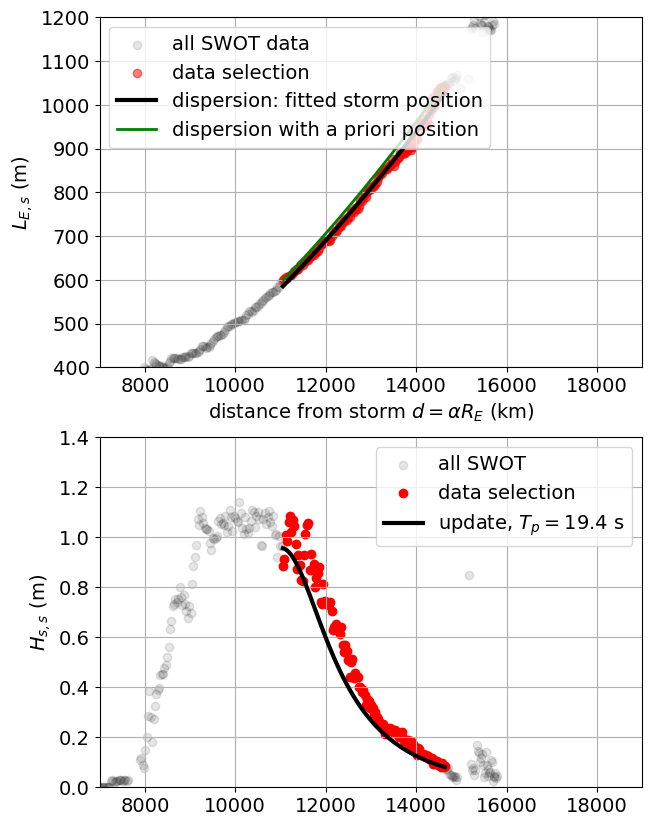

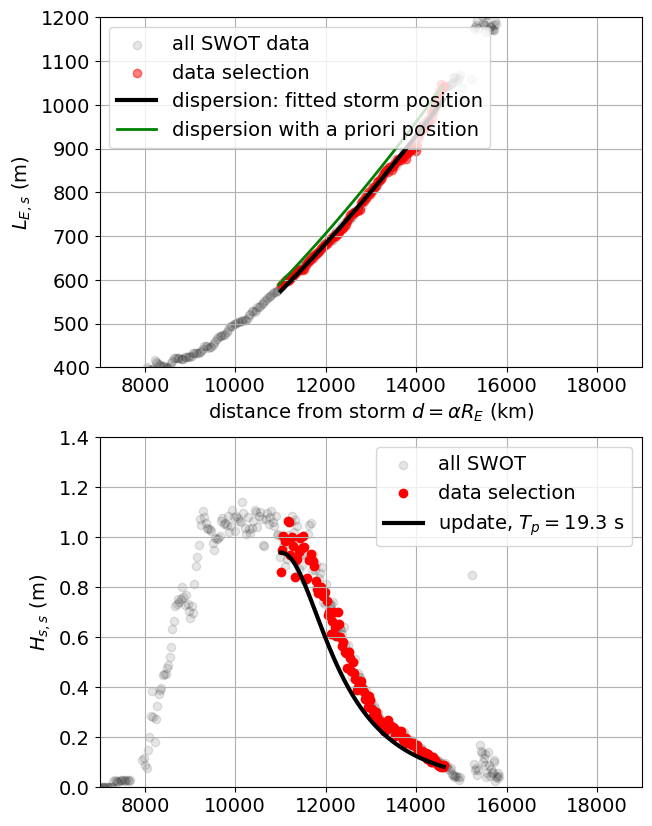

In [138]:
# Fits for getting Tp in the storm ... 
# We need to define some criteria for "good" data ...
thrOK=0.015;thrH=0.1
RE=40000/(2*np.pi)
ncross=2
[nb]=np.shape(L3Snc.Lpart.values)
maskfit=np.zeros(nb)
Hfit=L3Snc.Hpart_nonoise.values
distshift=np.zeros(2)
timeshift=np.zeros(2)
coeffs=np.zeros(2)
Tps=np.zeros(2)


for side in [0,1]:
    
    inda=np.where((L3Snc.Lpart[0+side:-1:ncross].values > rl[0]) & (L3Snc.Lpart[0+side:-1:ncross].values < rl[1]) & (L3Snc.Hpart[0+side:-1:ncross].values > thrH) )[0]
    
    #print('inda:',inda)

    # Initialize a list to hold sub-arrays
    consecutive_arrays = []

    # Initialize the first sequence
    current_sequence = [inda[0]]

    # Loop through the array to find consecutive sequences
    for i in range(1, len(inda)):
        if inda[i] == inda[i - 1] + 1:  # Check if current number is consecutive
            current_sequence.append(inda[i])  # Add to the current sequence
        else:
            consecutive_arrays.append(np.array(current_sequence))  # Store the current sequence
            current_sequence = [inda[i]]  # Start a new sequence

    # Append the last sequence
    consecutive_arrays.append(np.array(current_sequence))

    # Print the result
    lenmax=0
    for seq in consecutive_arrays:
        #print(len(seq),seq)
        if (len(seq) > lenmax): 
            lenmax=len(seq)
            indac=np.array(seq)
    
    ind0=ncross*indac+side
    a0=L3Snc.alpha.values  #[0+side:-1:2]
    costfun='LS'
    incognita=[0,0]
    xopt = minimize(eval('swell.Lmodel'), incognita, args=((L3Snc.Lpart[ind0].values,a0[ind0],costfun,tds),),\
                     method='Nelder-Mead',options={'disp': False})
    print('side:',side,', result:',xopt.x)

    fj,Lj = swell.Lmodel_eval(a0,tds,xopt.x)

    # extends to shorter distances ... 
    i1=ind0[0]
    Hmax=Hfit[i1]
    for ii in np.arange(ind0[0],side,-ncross):
        mis=np.abs(Lj[ii]-Lpart[ii])/Lj[ii] 
        if (mis < thrOK*2) & (Hfit[i1]/Hmax >=0.98) & (L3Snc.Lpart[i1] >=500)  :
            i1=ii
        else:
            break 
    
    i2=ind0[-1]
    Hmin=Hfit[i2]
    for ii in np.arange(i2,nb,2):
        mis=np.abs(Lj[ii]-Lpart[ii])/Lj[ii] 
        if (mis < thrOK) & (Hfit[i2] >=thrH) & (Hfit[i2]/Hmin <=1.02) :
            i2=ii
            Hmin=Hfit[i2]
        else:
            break 
    
    # now fits the heights 
    inds=np.arange(i1,i2,ncross) 
    maskfit[inds]=1
    xopt = minimize(eval('swell.Lmodel'), incognita, args=((L3Snc.Lpart[inds].values,a0[inds],costfun,tds),),\
                     method='Nelder-Mead',options={'disp': False}) 
    print(i1,i2,'side:',side,', final result L fit:',i1,i2,'##',xopt.x)

    # First we adjust the distance / time 
    ashift=xopt.x[0];tshift=xopt.x[1]
    distshift[side]=ashift
    timeshift[side]=tshift
    fj,Lj=swell.Lmodel_eval(a0,tds,[ashift,tshift])
    fj0,Lj0=swell.Lmodel_eval(a0,tds,[0,0])
    alp=a0+ashift

    print('ASHIFT:',ashift,tshift)
    f0=0.0532;

    costfun='LS'
    costpow=0
    gammaPM=2
    coeff=4E-3
    incognita=[0.06,coeff,gammaPM]
    xopt = minimize(eval('swell.Hmodel'), incognita, args=((Hfit[inds],a0[inds],fj[inds],gammaPM,costpow,costfun),),\
                    method='Nelder-Mead',options={'disp': False})
    
    alphaP=0.0081*9.81**2/(2*np.pi)**4
    factor=4*np.sqrt(alphaP/2)/RE
    radius=xopt.x[1]/factor

    f0=xopt.x[0]
    Tp=1/f0
    print('result:',xopt.x,Tp,'Toba H:',0.062*np.sqrt(9.81*1*Tp**3),f' r={radius:6.0f} km' )
    coeff=xopt.x[1]

    HJ8=swell.Hmodel_eval(alp,fj,gammaPM,[f0,coeff,gammaPM])
    print('Misfit:',np.sum((HJ8[inds]-Hfit[inds])**2))
    HJ8b=swell.Hmodel_eval(alp,fj,gammaPM,[f0*1.05,coeff*1.05**3,gammaPM])
    HJ8c=swell.Hmodel_eval(alp,fj,gammaPM,[f0/1.02,coeff,gammaPM])



    HJ=coeff*np.sqrt(fj**-5*np.exp(-1.25*(fj/f0)**-4)*gammaPM**(np.exp(-(fj-f0)**2/(2*(0.07*f0)**2))))/np.sqrt(alp*np.sin(alp))

    fig,axs=plt.subplots(2,1,figsize=(7,10))
    ax=axs[0]
    ax.scatter(RE*alp[0:-1:ncross],L3Snc.Lpart[0:-1:ncross].values,c='k',alpha=0.1,linewidth=1,label='all SWOT data');
    ax.scatter(RE*alp[inds],L3Snc.Lpart[inds].values,c=cols,alpha=0.5,linewidth=1,label='data selection');
    ax.plot(RE*alp[inds],Lj[inds],c='k',alpha=1,linewidth=3,label='dispersion: fitted storm position');
    ax.plot(RE*a0[inds],Lj0[inds],c='g',alpha=1,linewidth=2,label='dispersion with a priori position');
    ax.set_ylim(Lrange);
    ax.set_xlim(drange);
    ax.set_ylabel(r'$L_{E,s}$ (m)');
    ax.set_xlabel(r'distance from storm $d=\alpha R_E$ (km)');
    leg = ax.legend(loc='upper left', fontsize=14)

    ax=axs[1]
    ax.scatter(RE*alp[0:-1:2],L3Snc.Hpart_nonoise[0:-1:2].values,c='k',alpha=0.1,linewidth=1,label='all SWOT');
    #ax.scatter(RE*alp[inds],L3Snc.Hpart[inds].values,c='c',alpha=0.3,linewidth=1,label='data selection');
    ax.scatter(RE*alp[inds],Hfit[inds],c=cols,alpha=1,linewidth=1,label='data selection') #'denoised');
    indm=int(np.median(inds))
    #ax.plot(RE*alp[inds],L3Snc.Hpart[indm].values*(alp[inds]/alp[indm])**-9,c='k',alpha=0.8,linewidth=3,label=r'$\alpha^{-9}$');
    #ax.plot(RE*alp[inds],HJ[inds],c='g',alpha=0.5,linewidth=3,label='standard spectrum');
    
    #ax.plot(RE*alp[inds],1.05*HJ8b[inds],c='b',alpha=1,linewidth=1,label='update, $T_p=$'+f'{1/(f0*1.05):03.1f}'+' s');
    ax.plot(RE*alp[inds],HJ8[inds],c='k',alpha=1,linewidth=3,label='update, $T_p=$'+f'{1/f0:03.1f}'+' s');
    #ax.plot(RE*alp[inds],0.95*HJ8c[inds],c='b',alpha=1,linewidth=2,label='update, $T_p=$'+f'{1.02/f0:03.1f}'+' s');
    ax.set_ylim([0,Hmaxp]);
    #ax.set_ylim([0,0.5]);
    ax.set_ylabel(r'$H_{s,s}$ (m)');
    ax.set_xlim(drange);
    #leg = ax.legend(loc='upper right', fontsize=14)
    leg = ax.legend(loc='upper right', fontsize=14)

    fig.savefig('fig1_decay3_'+str(cycle)+'_'+str(tracks)+'_'+str(side)+'_final_2pe.pdf')
   

In [117]:
L3Snc = L3Snc.assign({
    'maskfit': (('dimb',), maskfit),
    'distshiftL':  distshift[0],
    'timeshiftL':  timeshift[0],
    'distshiftR':  distshift[1],
    'timeshiftR':  timeshift[1],
    'coefL':  coeffs[0],
    'TpL':  Tps[0],
    'coefR':  coeffs[1],
    'TpR':  Tps[1]
})




len: 412 478 83 ## 3676.503145603953 4289.884593268301
E (in PJ, GWh) : 1.8907928525613678 525.2202368226021 12930339177.25991
len: 370 478 131 ## 3676.503145603953 3676.503145603953
E (in PJ, GWh) : 21.529216951062704 5980.3380419618625 147229283747.79178
Misfit: 1.5742203240776131
len: 417 479 79 ## 3711.6610933219913 4306.800782968877
E (in PJ, GWh) : 1.755041897040451 487.51163806679193 12001995336.661642
len: 377 479 126 ## 3711.6610933219913 3711.6610933219913
E (in PJ, GWh) : 20.194691825390237 5609.636618163954 138103026214.00394
Misfit: 2.704902742908823


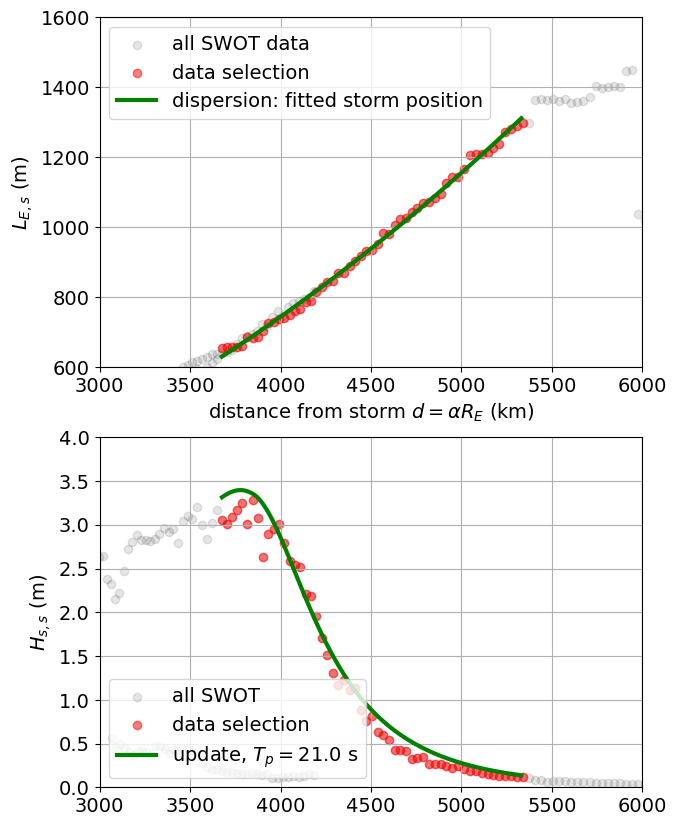

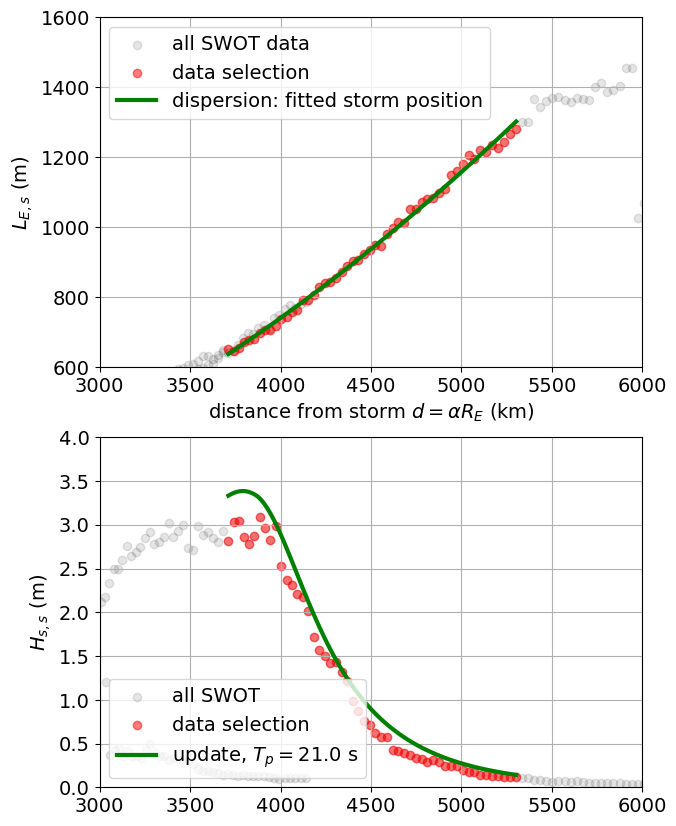

In [118]:
# Now we compute radiated energy 
thrOK=0.01;thrH=0.1
RE=40000/(2*np.pi)
ncross=2
[nb]=np.shape(L3Snc.Lpart.values)

a0=L3Snc.alpha.values 
PJ575=np.zeros(2)
PJ845=np.zeros(2)
for side in [0,1]:
    
    ind0=np.where((L3Snc.maskfit[0+side:-1:2].values ==1))[0]
    inds=2*ind0+side
    inda=np.where((L3Snc.Lpart[0+side:-1:ncross].values > 845 ) & (L3Snc.maskfit[0+side:-1:2].values ==1))[0]
    if len(inda) > 0:
       ind0=2*inda+side
    
       i1=ind0[0]
       i2=ind0[-1]
       dal=0.002
       alin=np.arange(a0[i1]+ashift,a0[i2]+ashift,dal)
       print('len:',i1,i2,len(alin),'##',RE*alp[inds[0]],RE*alin[0])
       fjlin,Ljlin=swell.Lmodel_eval(alin-ashift,tds,[distshift[side],timeshift[side]])
       HJ8l=swell.Hmodel_eval(alin,fjlin,gammaPM,[f0,coeff,gammaPM])
    
       E=np.sum((HJ8l/4)**2)*1026*9.81*dal*(RE*1000)**2

       ratio=E/(1026*coeff**2 * RE**2/ 9.81 )

       PJ845[side]=E/1E15
    
       print('E (in PJ, GWh) :',PJ845[side], E/(3600*1E9), ratio)
    
    inda=np.where((L3Snc.Lpart[0+side:-1:ncross].values > 575 ) & (L3Snc.maskfit[0+side:-1:2].values ==1))[0]
    ind0=2*inda+side
    
    i1=ind0[0]
    i2=ind0[-1]
    dal=0.002
    alin=np.arange(a0[i1]+ashift,a0[i2]+ashift,dal)
    print('len:',i1,i2,len(alin),'##',RE*alp[inds[0]],RE*alin[0])
    fjlin,Ljlin=swell.Lmodel_eval(alin-ashift,tds,[distshift[side],timeshift[side]])
    HJ8l=swell.Hmodel_eval(alin,fjlin,gammaPM,[f0,coeff,gammaPM])
    
    E=np.sum((HJ8l/4)**2)*1026*9.81*dal*(RE*1000)**2

    ratio=E/(1026*coeff**2 * RE**2/ 9.81 )

    PJ575[side]=E/1E15
    
    print('E (in PJ, GWh) :',PJ575[side], E/(3600*1E9), ratio)
    
    HJ8=swell.Hmodel_eval(alp,fj,gammaPM,[f0,coeff,gammaPM])
    print('Misfit:',np.sum((HJ8[inds]-L3Snc.Hpart[inds].values)**2))
 


    HJ=coeff*np.sqrt(fj**-5*np.exp(-1.25*(fj/f0)**-4)*gammaPM**(np.exp(-(fj-f0)**2/(2*(0.07*f0)**2))))/np.sqrt(alp*np.sin(alp))

    fig,axs=plt.subplots(2,1,figsize=(7,10))
    ax=axs[0]
    ax.scatter(RE*alp[side:-1:2],L3Snc.Lpart[side:-1:2].values,c='k',alpha=0.1,linewidth=1,label='all SWOT data');
    ax.scatter(RE*alp[inds],L3Snc.Lpart[inds].values,c='red',alpha=0.5,linewidth=1,label='data selection');
    #ax.plot(RE*alp[inds],Lj[inds],c='k',alpha=1,linewidth=3,label='dispersion: fitted storm position');
    ax.plot(RE*alin,Ljlin,c='g',alpha=1,linewidth=3,label='dispersion: fitted storm position');
    ax.set_ylim(Lrange);
    ax.set_xlim(drange);
    ax.set_ylabel(r'$L_{E,s}$ (m)');
    ax.set_xlabel(r'distance from storm $d=\alpha R_E$ (km)');
    leg = ax.legend(loc='upper left', fontsize=14)

    ax=axs[1]
    ax.scatter(RE*alp[side:-1:2],L3Snc.Hpart[side:-1:2].values,c='k',alpha=0.1,linewidth=1,label='all SWOT');
    ax.scatter(RE*alp[inds],L3Snc.Hpart[inds].values,c='red',alpha=0.5,linewidth=1,label='data selection');
    indm=int(np.median(inds))
    #ax.plot(RE*alp[inds],HJ8[inds],c='b',alpha=1,linewidth=3,label='update, $T_p=$'+f'{1/f0:03.1f}'+' s');
    ax.plot(RE*alin,HJ8l,c='g',alpha=1,linewidth=3,label='update, $T_p=$'+f'{1/f0:03.1f}'+' s');
    ax.set_ylim([0,Hmaxp]);
    ax.set_ylabel(r'$H_{s,s}$ (m)');
    ax.set_xlim(drange);
    #leg = ax.legend(loc='upper right', fontsize=14)
    leg = ax.legend(loc='lower left', fontsize=14)

In [98]:
L3Snc = L3Snc.assign({
    'PJ575L': PJ575[0], 
    'PJ575R': PJ575[1], 
    'PJ845L': PJ845[0], 
    'PJ845R': PJ845[1]
})

fileout=folder+'SWOT_L3_LR_WIND_WAVE_'+cycle+'_'+tracks+'_'+tag+'_part.nc'
print('saving file:',fileout)
L3Snc.to_netcdf(fileout)
print('tds:',tds)

saving file: /media/ardhuin/FabLinux/SWOT_SPECTRA_TEST3/SWOT_L3_LR_WIND_WAVE_026_024_v2.1_light_part.nc
tds: 266116.187168128


In [391]:
15.5/19.4

0.7989690721649485

In [393]:
0.8**17

0.022517998136852502

In [394]:
0.09/4.5

0.02

In [52]:
A=np.array([20.1, 20.5, 20.2, 20.3, 19.1, 19.5, 20.0, 20.5, 20.1, 20.3, 19.4, 19.1])
A=np.array([19.6, 19.3, 19.7, 19.3, 19.7, 19.0, 18.4, 19.9, 19.5, 19.3, 19.7, 19.3, 19.6, 19.0, 18.4])
A=np.array([20.1,19.5, 20.2, 19.6, 18.9   ])
A=np.array([19.1, 19.1, 18.9, 19.4, 18.7, 18.7, 18.8, 18.8, 19.1, 18.7, 19.3, 18.8, 18.6 ,19.4])
print(np.median(A),np.std(A))



18.85 0.26380264732313397
